<p style="font-size:36px;text-align:center"> <b>StackOverflow Tag Prediction</b> </p>

<h1>1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>
Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers.<br />
<br />
Stack Overflow is something which every programmer use one way or another. Each month, over 50 million developers come to Stack Overflow to learn, share their knowledge, and build their careers. It features questions and answers on a wide range of topics in computer programming. The website serves as a platform for users to ask and answer questions, and, through membership and active participation, to vote questions and answers up or down and edit questions and answers in a fashion similar to a wiki or Digg. As of April 2014 Stack Overflow has over 4,000,000 registered users, and it exceeded 10,000,000 questions in late August 2015. Based on the type of tags assigned to questions, the top eight most discussed topics on the site are: Java, JavaScript, C#, PHP, Android, jQuery, Python and HTML.<br />
<br />
</p>

<p style='font-size:18px'><b> Problem Statemtent </b></p>

Suggest the tags based on the content that was there in the question posted on Stackoverflow.<br>
<b> Source:  </b> https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/


<h2> 1.2 Real World / Business Objectives and Constraints </h2>

1. Predict as many tags as possible with high precision and recall.
2. Incorrect tags could impact customer experience on StackOverflow.
3. No strict latency constraints.

<h2> Assignments.</h2>
#### Task 1 : Use bag of words upto 4 grams and compute the micro f1 score with Logistic regression(OvR) [Click Here](#Task1)
#### Task 2 : Perform hyperparameter tuning on alpha (or lambda) for Logistic regression to improve the performance using GridSearch [Click Here](#Task2)
#### Task 3 : Try OneVsRestClassifier with Linear-SVM (SGDClassifier with hinge-loss) [Click Here](#Task3)


<h1>2. ML problem-formulation </h1>

<h2> 2.1 Data Overview</h2>

Refer: https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data
<br>
All of the data is in 2 files: Train and Test.<br />
<pre>
<b>Train.csv</b> contains 4 columns: Id,Title,Body,Tags.<br />
<b>Test.csv</b> contains the same columns but without the Tags, which you are to predict.<br />
<b>Size of Train.csv</b> - 6.75GB<br />
<b>Size of Test.csv</b> - 2GB<br />
<b>Number of rows in Train.csv</b> = 6034195<br />
</pre>
The questions are randomized and contains a mix of verbose text sites as well as sites related to math and programming. The number of questions from each site may vary, and no filtering has been performed on the questions (such as closed questions).<br>
<br>

<b>Data Field Explaination -</b><br>

Dataset contains 6,034,195 rows. The columns in the table are:<br />
<pre>
<b>Id</b> - Unique identifier for each question<br />
<b>Title</b> - The question's title<br />
<b>Body</b> - The body of the question<br />
<b>Tags</b> - The tags associated with the question in a space-seperated format (all lowercase, should not contain tabs '\t' or ampersands '&')<br />
</pre>

<br />


<h2>2.2 Mapping the real-world problem to a Machine Learning Problem </h2>

<h3> 2.2.1 Type of Machine Learning Problem </h3>

<p> It is a multi-label classification problem  <br>
<b>Multi-label Classification</b>: Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A question on Stackoverflow might be about any of C, Pointers, FileIO and/or memory-management at the same time or none of these. <br>
__Credit__: http://scikit-learn.org/stable/modules/multiclass.html
</p>

<h3>2.2.2 Performance metric </h3>

<b>Micro-Averaged F1-Score (Mean F Score) </b>: 
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

<i>F1 = 2 * (precision * recall) / (precision + recall)</i><br>

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. <br>

<b>'Micro f1 score': </b><br>
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.
<br>

<b>'Macro f1 score': </b><br>
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
<br>

https://www.kaggle.com/wiki/MeanFScore <br>
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html <br>
<br>
<b> Hamming loss </b>: The Hamming loss is the fraction of labels that are incorrectly predicted. <br>
https://www.kaggle.com/wiki/HammingLoss <br>

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

# fancy modules encountered in this case-study
import winsound
from prettytable import PrettyTable

In [2]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


In [3]:
# these methods will be used while converting tags to multi-label o/p variables
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

<h1> 3. Exploratory Data Analysis </h1>
<br> <b>Note: </b> The EDA has been performed in the original file. Here, we will only summarize the findings

<h2> 3.1 Data Loading and Cleaning </h2><br>
We will use only Train.csv for our case-study since the actual tags/labels are not provided for Test.csv <br>
We used pandas with SQLite to load the data and on checking for duplicates found 30% of the data points to be duplicate questions. After removing the duplicates, we are left with roughly 4M data points

<h2> 3.2 Analysis of Tags </h2> <br>
In our tag-analysis, we found that a few tags occur a very large no of times but most of them occur sparsely(this supports the reason behind choosing Micro-averaged F1 score as our perf metric). We also found that most of the questions have 2 or 3 tags. We also observed that majority of the most frequent tags are programming languages(C#, Java, pHp, JavaScript ...) and Android, iOS, Linux, Windows are among the top most frequent Operating Systems

<h2> 3.3 Cleaning and Preprocessing of data </h2><br>
<ol> 
    <li> Sample 0.5M data points </li>
    <li> Separate Code from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> <b> Give more weightage to title : Add title three times to the question </b> </li>
   
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

<h3>Now we load our preprocessed data from the DB</h3>

In [4]:
#Taking the 0.5 Million entries from the db to a dataframe.
start = datetime.now()
read_db = 'Titlemoreweight.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT * FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:17.783215


In [5]:
print(preprocessed_data.shape)
preprocessed_data.head()

(500000, 6)


,question,code,tags,words_pre,words_post,is_code
0,dynam datagrid bind silverlight dynam datagrid...,['MyClass myInstance = new MyClass();\ndataGri...,c# silverlight data-binding,904,252,1
1,dynam datagrid bind silverlight dynam datagrid...,['MyClass myInstance = new MyClass();\ndataGri...,c# silverlight data-binding columns,904,252,1
2,java.lang.noclassdeffounderror javax servlet j...,"['&lt;%@taglib prefix=""c"" uri=""http://java.sun...",jsp jstl,745,463,1
3,java.sql.sqlexcept microsoft odbc driver manag...,"['try {\n Class.forName(""sun.jdbc.odbc.Jdbc...",java jdbc,1056,249,1
4,better way updat feed fb php sdk better way up...,"['$data = array(""message"" =&gt; ""Hello World!""...",facebook api facebook-php-sdk,607,233,1


<h1>4. Machine Learning Models </h1>

<h2>4.1 Converting string Tags to multilable output variables</h2>

In [6]:
# tokenizer param is necessary here as it will override the default tokenization step within CountVectorizer
# each word will contain everything until a space is encountered
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), analyzer='word', binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])
print(multilabel_y.shape)

(500000, 29587)


<h3>Selecting 500 Tags</h3>(We will sample the number of tags instead considering all of them b'coz of the computational constraint of the device)

In [8]:
questions_explained = []
total_tags = multilabel_y.shape[1]
total_qs = preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

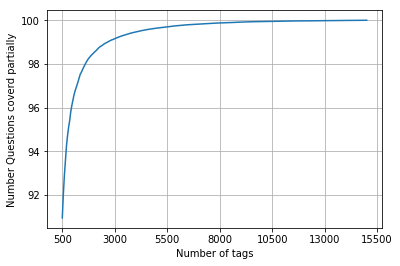

with  5500 tags we are covering  99.157 % of questions
with  500 tags we are covering  90.956 % of questions


In [9]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [10]:
# we will be considering 500 tags(as they cover 90% of the questions in our sample)
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 45221 out of  500000


<h2>4.2 Splitting our data into train and test sub-sets(80-20 split) </h2>

In [10]:
# these subsets of data will be used in our tasks 2 and 3
train_datasize = int(0.8 * total_qs)

x_train = preprocessed_data.head(train_datasize)
x_test = preprocessed_data.tail(total_qs - train_datasize)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:total_qs,:]

In [11]:
print("Number of data points in train data :", x_train.shape[0])
print("Number of data points in test data :", y_test.shape[0])

Number of data points in train data : 400000
Number of data points in test data : 100000


<h2>4.3 Featurizing i/p data</h2>

<h3>4.3.1 Using Count vectorizer</h3>

<a id='Task1'>
# *Task 1: Apply BOW upto 4 grams and compute the micro F1 score with Logistic regression(OvR) *</a>

<h4>Here we are limiting the training data-set size to 100,000 due to computational power contraint( as we are considering n-gram range till 4)</h4>

In [12]:
# fetching the train and test subsets from the data frame
train_size = 100000
test_size = 20000

x_train_count = preprocessed_data[0:train_size]
x_test_count = preprocessed_data[train_size:train_size+test_size]

y_train_count = multilabel_yx[0:train_size,:]
y_test_count = multilabel_yx[train_size:train_size+test_size,:]

In [14]:
# vectorize the i/p data : questions
start = datetime.now()
bow_vectorizer = CountVectorizer(min_df=0.00009, max_features=200000, tokenizer = lambda x: x.split(), ngram_range=(1,4))
x_train_multilabel_bow = bow_vectorizer.fit_transform(x_train_count['question'])
x_test_multilabel_bow = bow_vectorizer.transform(x_test_count['question'])
print("Time taken to run this cell :", datetime.now() - start)
winsound.MessageBeep(1)

Time taken to run this cell : 0:01:23.258221


In [16]:
print("Dimensions of train data X:",x_train_multilabel_bow.shape, "Y :",y_train_count.shape)
print("Dimensions of test data X:",x_test_multilabel_bow.shape,"Y:",y_test_count.shape)

Dimensions of train data X: (100000, 109588) Y : (100000, 500)
Dimensions of test data X: (20000, 109588) Y: (20000, 500)


<h3>Apply Logistic Regression on the training set and compute the performance metric on test data </h3>

In [22]:
start = datetime.now()
# train the LR model 
classifier = OneVsRestClassifier(LogisticRegression(penalty='l1', random_state=42))
classifier.fit(x_train_multilabel_bow, y_train_count)
predictions = classifier.predict (x_test_multilabel_bow)

# print the various performance metrices
print("Accuracy :",metrics.accuracy_score(y_test_count, predictions))
print("Hamming loss :",metrics.hamming_loss(y_test_count,predictions))


precision = precision_score(y_test_count, predictions, average='micro')
recall = recall_score(y_test_count, predictions, average='micro')
f1 = f1_score(y_test_count, predictions, average='micro')
 
print("\nMicro-average quality numbers -")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_count, predictions, average='macro')
recall = recall_score(y_test_count, predictions, average='macro')
f1 = f1_score(y_test_count, predictions, average='macro')
 
print("\nMacro-average quality numbers -")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\n")
print (metrics.classification_report(y_test_count, predictions))
print("Time taken to run this cell :", datetime.now() - start)
winsound.MessageBeep(2)

Accuracy : 0.18835
Hamming loss : 0.0032621

Micro-average quality numbers -
Precision: 0.5755, Recall: 0.3706, F1-measure: 0.4509

Macro-average quality numbers -
Precision: 0.4145, Recall: 0.2819, F1-measure: 0.3226


             precision    recall  f1-score   support

          0       0.89      0.71      0.79      1617
          1       0.53      0.30      0.38      1833
          2       0.65      0.40      0.50      1164
          3       0.60      0.41      0.49       264
          4       0.60      0.39      0.47      1465
          5       0.61      0.44      0.51       793
          6       0.68      0.40      0.50      1119
          7       0.80      0.60      0.69      1432
          8       0.24      0.13      0.17       491
          9       0.55      0.46      0.50       539
         10       0.32      0.27      0.30       660
         11       0.56      0.47      0.51       919
         12       0.49      0.34      0.40       741
         13       0.41      0.31     

<h3>4.3.2 Using tf_Idf vectorizer</h3>

In [14]:
# vectorize the i/p data : questions
start = datetime.now()
inp_vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = inp_vectorizer.fit_transform(x_train['question'])
x_test_multilabel = inp_vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:09:26.958642


In [15]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (400000, 94927) Y : (400000, 500)
Dimensions of test data X: (100000, 94927) Y: (100000, 500)


<a id='Task2'>
# *Task 2: Apply Logistic Regression(find the best alpha using hyperparameter tuning) with OneVsRest Classifier *</a>

<h3> Hyperparameter Tuning</h3>

In [17]:
start = datetime.now()
alpha = [10 ** x for x in range(-10, -3, 2)]
perf_metric = []
for i in alpha:
    clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha=i, penalty='l1', random_state=42), n_jobs=-1)
    clf.fit(x_train_multilabel, y_train)
    predictions = clf.predict (x_test_multilabel)
    # append the micro-f1 score for the particular alpha trained classifier
    perf_metric.append(f1_score(y_test, predictions, average='micro'))
print("Time taken to run this cell :", datetime.now() - start)    

Time taken to run this cell : 0:57:43.978800


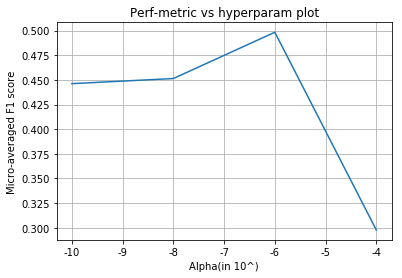

In [22]:
# plot the perf metric for each hyperparam(alpha)
fig, ax = plt.subplots()
ax.plot(perf_metric)
xlabel = list(range(-11, -3))
ax.set_xticklabels(xlabel)
plt.title("Perf-metric vs hyperparam plot")
plt.xlabel("Alpha(in 10^)")
plt.ylabel("Micro-averaged F1 score")
plt.grid()
plt.show()

<h3>Training the model with best hyperparameter</h3>

In [23]:
start = datetime.now()
# fetching the best alpha
best_alpha = alpha[np.argmax(perf_metric)]
print('Best hyperparam(alpha) : ',best_alpha)

# train the LR model with the best alpha
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=best_alpha, penalty='l1',  random_state=42), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)

# print the various performance metrices
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss :",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("\nMicro-average quality numbers -")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("\nMacro-average quality numbers -")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\n")
print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Best hyperparam(alpha) :  1e-06
Accuracy : 0.25315
Hamming loss : 0.00271044

Micro-average quality numbers -
Precision: 0.6988, Recall: 0.3872, F1-measure: 0.4983

Macro-average quality numbers -
Precision: 0.5563, Recall: 0.3100, F1-measure: 0.3835


             precision    recall  f1-score   support

          0       0.93      0.75      0.83      5519
          1       0.65      0.40      0.49      8190
          2       0.79      0.42      0.55      6529
          3       0.80      0.51      0.62      3231
          4       0.75      0.48      0.58      6430
          5       0.80      0.42      0.55      2879
          6       0.84      0.56      0.67      5086
          7       0.86      0.59      0.70      4533
          8       0.57      0.15      0.24      3000
          9       0.80      0.58      0.67      2765
         10       0.57      0.21      0.30      3051
         11       0.66      0.42      0.51      3009
         12       0.58      0.32      0.42      2630
    

<a id='Task3'>
# *Task 3: Apply OneVsRestClassifier with Linear-SVM *</a>

<h3> Hyperparameter Tuning</h3>

In [24]:
start = datetime.now()
alpha = [10 ** x for x in range(-10, -3, 2)]
perf_metric = []
for i in alpha:
    clf = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=i, penalty='l1', random_state=42), n_jobs=-1)
    clf.fit(x_train_multilabel, y_train)
    predictions = clf.predict (x_test_multilabel)
    # append the micro-f1 score for the particular alpha trained classifier
    perf_metric.append(f1_score(y_test, predictions, average='micro'))
print("Time taken to run this cell :", datetime.now() - start)    

Time taken to run this cell : 0:46:54.992585


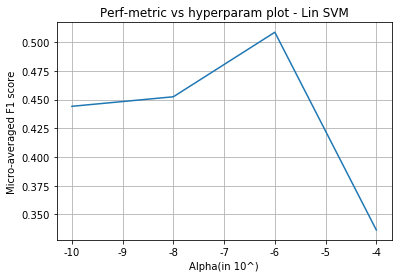

In [25]:
# plot the perf metric for each hyperparam(alpha)
fig, ax = plt.subplots()
ax.plot(perf_metric)
xlabel = list(range(-11, -3))
ax.set_xticklabels(xlabel)
plt.title("Perf-metric vs hyperparam plot - Lin SVM")
plt.xlabel("Alpha(in 10^)")
plt.ylabel("Micro-averaged F1 score")
plt.grid()
plt.show()

<h3>Training the model with best hyperparameter</h3>

In [27]:
start = datetime.now()
# fetching the best alpha
best_alpha = alpha[np.argmax(perf_metric)]
print('Best hyperparam(alpha) : ',best_alpha)

# train the Lin SVM model with the best alpha
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=best_alpha, penalty='l1',  random_state=42), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)

# print the various performance metrices
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss :",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("\nMicro-average quality numbers -")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("\nMacro-average quality numbers -")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\n")
print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Best hyperparam(alpha) :  1e-06
Accuracy : 0.26196
Hamming loss : 0.00267594

Micro-average quality numbers -
Precision: 0.7032, Recall: 0.3984, F1-measure: 0.5086

Macro-average quality numbers -
Precision: 0.5512, Recall: 0.3097, F1-measure: 0.3722


             precision    recall  f1-score   support

          0       0.92      0.78      0.85      5519
          1       0.57      0.46      0.51      8190
          2       0.75      0.45      0.56      6529
          3       0.77      0.53      0.63      3231
          4       0.72      0.50      0.59      6430
          5       0.72      0.48      0.58      2879
          6       0.82      0.57      0.67      5086
          7       0.82      0.63      0.71      4533
          8       0.56      0.16      0.25      3000
          9       0.77      0.62      0.69      2765
         10       0.55      0.19      0.28      3051
         11       0.66      0.44      0.53      3009
         12       0.54      0.37      0.44      2630
    

<h2> Conclusion: </h2> We observe that our models with both count vectorized and tf-idf vectorized input give similar results. Lin SVM on tf-idf vectorized questions performed slightly better with a micro-averaged F1 score of ~ 0.51

In [4]:
class bcolors:
    GREEN = '\033[1;92m'
    ENDC = '\033[0m'
    RED = '\033[1;31m'
    BLUE = '\033[1;94m'
    YELLOW = '\033[1;93m'
    
ptt = PrettyTable()
#x.border = 
ptt.field_names = [bcolors.BLUE +"ML Models", "Micro-averaged F1 score", "Hamming Loss" + bcolors.ENDC]
ptt.add_row([bcolors.GREEN +"LR(on count vectorized data)", 0.451, 0.003])
ptt.add_row([bcolors.GREEN +"LR(on tf-idf vectorized data)", 0.498, 0.003])
ptt.add_row([bcolors.YELLOW +"Lin SVM(on tf-idf vectorized data)", 0.509, 0.003])

print("Final Results : (These metrices have been obtained using hyperparameter tuning)")
print(ptt)

Final Results : (These metrices have been obtained using hyperparameter tuning)
+------------------------------------+-------------------------+--------------+
|             ML Models              | Micro-averaged F1 score | Hamming Loss |
+------------------------------------+-------------------------+--------------+
|    LR(on count vectorized data)    |          0.451          |    0.003     |
|   LR(on tf-idf vectorized data)    |          0.498          |    0.003     |
| Lin SVM(on tf-idf vectorized data) |          0.509          |    0.003     |
+------------------------------------+-------------------------+--------------+
